In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model # reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()



['measurement', 'station']

In [7]:
# We can view all of the classes that automap found;# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
Start of My Analysis.

In [9]:
# Find the tables...
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [16]:
conn = engine.connect()
mdata = pd.read_sql("select * from measurement", conn)
mdata


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [10]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Design a query to retrieve the last 12 months of precipitation data and plot the results




Text(0, 0.5, 'inches')

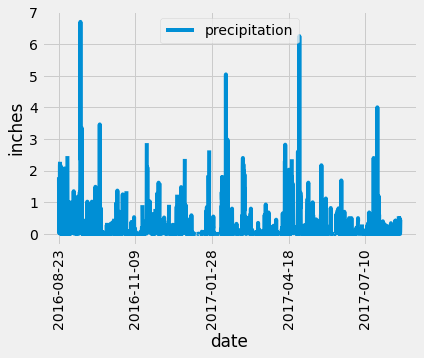

In [11]:

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date
# Calculate the date 1 year ago from the last data point in the database

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

year_ago

# Perform a query to retrieve the data and precipitation scores
Prcp_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()
   

# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_inches_oneyear = pd.DataFrame(Prcp_results, columns = ['date', 'precipitation'])
Precipitation_inches_oneyear

#Sort by date
Precipitation_inches_oneyear = Precipitation_inches_oneyear.sort_values(by=['date'])


# Reindex the dataframe by date
Precipitation_inches_oneyear = Precipitation_inches_oneyear.set_index(['date'])



# Use Pandas Plotting with Matplotlib to plot the data
Precipitation_inches_oneyear.plot(rot=90)
plt.xlabel('date')
plt.ylabel('inches')



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Precipitation_inches_oneyear.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Station.station).count()
num_station

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
most_active_stations = session.query(Station.name).filter(Station.station==active_stations[0][0]).all()

print (f'The most active station is {active_stations[0]}, {most_active_stations[0]}

for station in active_stations:
    print (station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_station = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==active_stations[0][0])
temp_station[0][0],temp_station[0][1],round(temp_station[0][2],2)

(54.0, 85.0, 71.66)

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==active_stations[0][0]).\
    filter(Measurement.date>=year_ago).all()
active_tobs[:10]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0)]

In [29]:
active_tobs_df = pd.DataFrame(active_tobs)
active_tobs_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


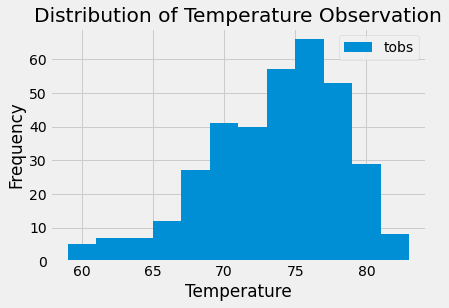

In [34]:
active_tobs_df.plot(kind="hist",bins=12)
plt.xlabel("Temperature")
plt.title("Distribution of Temperature Observation")
plt.savefig("Histogram.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
